In [1]:
import os
import zipfile
import requests
from io import BytesIO, StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score, adjusted_rand_score,
                             normalized_mutual_info_score)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## Dataset


El dataset de Turkish Music Emotion es un conjunto de datos clásico utilizado para la clasificación de emociones en música. Su objetivo principal es predecir la emoción de una pieza musical basándose en sus características acústicas.

**Descripción del Dataset**
- Propósito: El dataset fue creado para ayudar a desarrollar sistemas que puedan reconocer automáticamente la emoción de una canción. Las canciones provienen del género de música folclórica turca.
- Registros: Contiene 400 muestras de canciones, cada una etiquetada con una de las cuatro emociones principales.
- Problema: Es un problema de clasificación de múltiples clases, ya que el modelo debe predecir una de las cuatro emociones posibles.

##  Descripción de las Variables
El dataset incluye 50 variables de entrada (características musicales extraídas automáticamente) y 1 variable de salida (la emoción). Las características de entrada son medidas numéricas que describen la melodía, el ritmo y la tonalidad de cada pieza musical.

### Variables de Entrada (Características Acústicas):

Las 50 variables de entrada representan varias características musicales y de audio, incluyendo:

**Variables basadas en el tono y la melodía:** Características relacionadas con el contorno de la melodía y el rango de las notas.

**Variables rítmicas:** Características que describen la regularidad y complejidad del ritmo.

**Variables tonales:** Características relacionadas con la clave, la armonía y la progresión de acordes.

**Variables de intensidad:** Características que miden la energía o el volumen de la pieza.

### Variable de Salida (Objetivo):

- Emotion: La emoción que expresa la canción. Tiene cuatro valores posibles, que se corresponden con una de las siguientes emociones:
    - Neşe (Felicidad)
    - Hüzün (Tristeza)
    - Öfke (Ira)
    - Heyecan (Emoción/Excitación)

# CÓDIGO EJECUTADO DESDE EL FICHERO 'turkish_music_emotion.csv'

In [2]:
# ============================================================
# LEER EL FICHERO Y OBTENER LOS DATOS
# ============================================================
filename = 'turkish_music_emotion.csv'
df_read = pd.read_csv(filename)
print(f"\nArchivo leído  ({filename}). Dimensiones: {df_read.shape}")
df_read.head()




Archivo leído  (turkish_music_emotion.csv). Dimensiones: (400, 51)


,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,_MFCC_Mean_6,...,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy,Class
0,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,0.118,...,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970,relax
1,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,0.799,...,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967,relax
2,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,0.140,...,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963,relax
3,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,0.143,...,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968,relax
4,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,0.285,...,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957,relax


/tmp/ipykernel_12638/1905274795.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


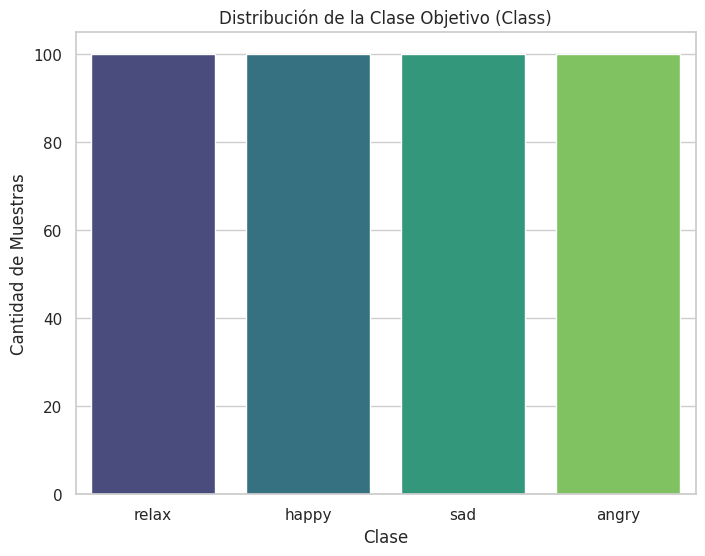

In [20]:
# ============================================================
# VARIABLE OBJETIVO
# ============================================================

class_counts = df_read['Class'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.title('Distribución de la Clase Objetivo (Class)')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Muestras')
plt.xticks(rotation=0)
plt.show()

In [3]:
label_col = 'Class'
y_true = df_read[label_col].values
X = df_read.drop(columns=[label_col]).copy()

In [4]:
# ============================================================
# FILTRAR SOLO VARIABLES NUMÉRICAS Y LIMPIAR NaNs
# ============================================================
X_num = X.select_dtypes(include=[np.number]).copy()
print("Variables numéricas detectadas:", X_num.shape[1])

# Si no hay columnas numéricas, alertamos
if X_num.shape[1] == 0:
    raise RuntimeError("No se detectaron variables numéricas. El dataset debe contener features numéricas para K-Means.")

# Si hay NaNs, imputamos por mediana (estrategia simple y robusta)
if X_num.isna().sum().sum() > 0:
    print("Imputando NaNs por mediana...")
    X_num = X_num.fillna(X_num.median())

display(X_num.describe().round(3))

Variables numéricas detectadas: 50


,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,_MFCC_Mean_6,...,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy
count,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,...,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000
mean,0.135,0.554,7.146,123.682,2.456,0.072,0.488,0.030,0.179,0.038,...,0.355,0.591,0.342,0.386,0.328,0.193,-0.000,1.762,0.770,0.967
std,0.064,0.051,2.280,34.234,0.799,0.538,0.295,0.276,0.195,0.204,...,0.335,0.358,0.316,0.348,0.056,0.047,0.105,0.930,0.072,0.004
min,0.010,0.302,3.580,48.284,0.323,-3.484,-0.870,-1.636,-0.494,-0.916,...,0.000,0.000,0.000,0.000,0.112,0.060,-0.285,0.187,0.530,0.939
25%,0.085,0.523,5.860,101.490,1.949,-0.263,0.281,-0.117,0.061,-0.078,...,0.067,0.264,0.060,0.061,0.291,0.160,-0.058,0.961,0.725,0.965
50%,0.128,0.553,6.734,120.132,2.390,0.068,0.464,0.044,0.181,0.050,...,0.247,0.612,0.247,0.296,0.333,0.190,-0.002,1.682,0.786,0.967
75%,0.174,0.583,7.824,148.986,2.860,0.413,0.686,0.198,0.288,0.151,...,0.612,1.000,0.565,0.671,0.367,0.226,0.063,2.243,0.824,0.969
max,0.431,0.703,23.475,195.026,5.996,1.937,1.622,1.126,1.055,0.799,...,1.000,1.000,1.000,1.000,0.488,0.340,0.442,4.486,0.908,0.977


In [5]:
# ============================================================
# ESCALADO (StandardScaler)
# ============================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
print("Escalado completado. Shape:", X_scaled.shape)

Escalado completado. Shape: (400, 50)


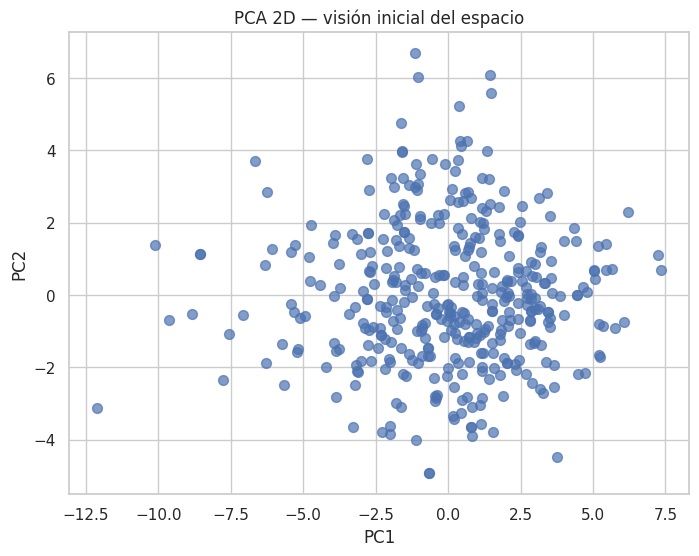

Varianza explicada por las 2 PCs: 0.245


In [6]:
# ============================================================
# PCA 2D — exploración visual previa
# ============================================================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=50, alpha=0.7)
plt.title("PCA 2D — visión inicial del espacio")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Varianza explicada por las 2 PCs:", pca.explained_variance_ratio_.cumsum()[-1].round(3))

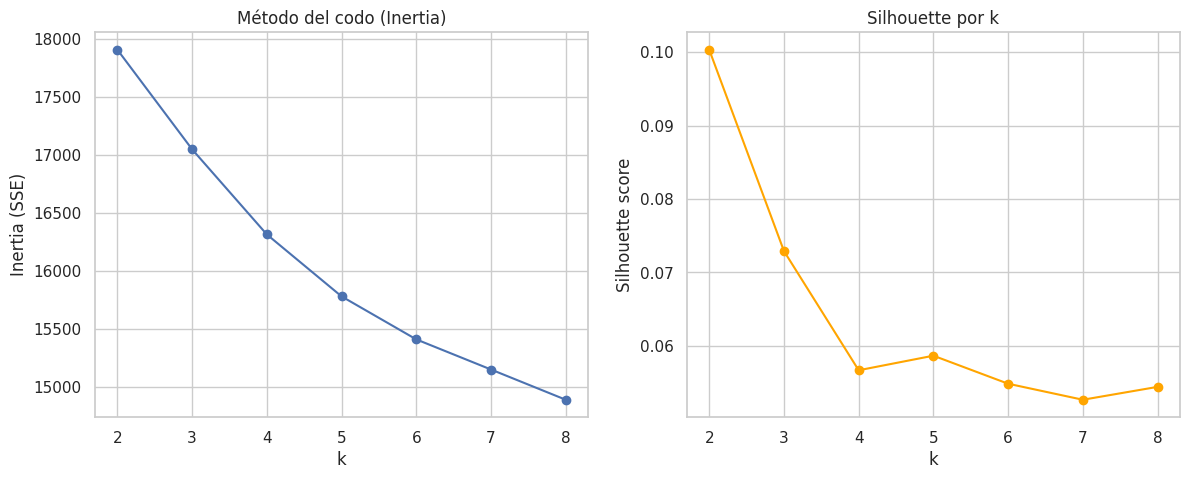

Silhouette por k: {2: 0.1, 3: 0.073, 4: 0.057, 5: 0.059, 6: 0.055, 7: 0.053, 8: 0.054}


In [7]:
# ============================================================
# ELECCIÓN DE K: Método del Codo + Silhouette (k=2..8)
# ============================================================
Ks = list(range(2,9))
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labs = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labs))

# Graficar codo + silhouette
fig, axs = plt.subplots(1,2,figsize=(14,5))
axs[0].plot(Ks, inertias, 'o-')
axs[0].set_title("Método del codo (Inertia)")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Inertia (SSE)")

axs[1].plot(Ks, sil_scores, 'o-', color='orange')
axs[1].set_title("Silhouette por k")
axs[1].set_xlabel("k")
axs[1].set_ylabel("Silhouette score")

plt.show()
print("Silhouette por k:", dict(zip(Ks, [round(s,3) for s in sil_scores])))

In [8]:
# ============================================================
# 9️APLICAR K-MEANS CON k óptimo (ejemplo: k_opt = argmax(silhouette))
# ============================================================
k_opt = Ks[int(np.argmax(sil_scores))]
print("k óptimo (silhouette):", k_opt)

km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
labels = km_final.fit_predict(X_scaled)

k óptimo (silhouette): 2


In [9]:
# ============================================================
# VALIDACIÓN INTERNA
# ============================================================
sil = silhouette_score(X_scaled, labels)
db = davies_bouldin_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)
print("Silhouette:", round(sil,3))
print("Davies-Bouldin:", round(db,3))
print("Calinski-Harabasz:", round(ch,1))

Silhouette: 0.101
Davies-Bouldin: 2.839
Calinski-Harabasz: 46.5


In [10]:
# VALIDACIÓN EXTERNA
if y_true is not None:
    # codificar etiquetas si son strings
    if y_true.dtype == object or y_true.dtype.name == 'category':
        y_codes = pd.Categorical(y_true).codes
    else:
        y_codes = y_true
    ari = adjusted_rand_score(y_codes, labels)
    print("Adjusted Rand Index (ARI):", round(ari,3))
else:
    print("Etiqueta no disponible: solo validación interna realizada.")

Adjusted Rand Index (ARI): 0.131


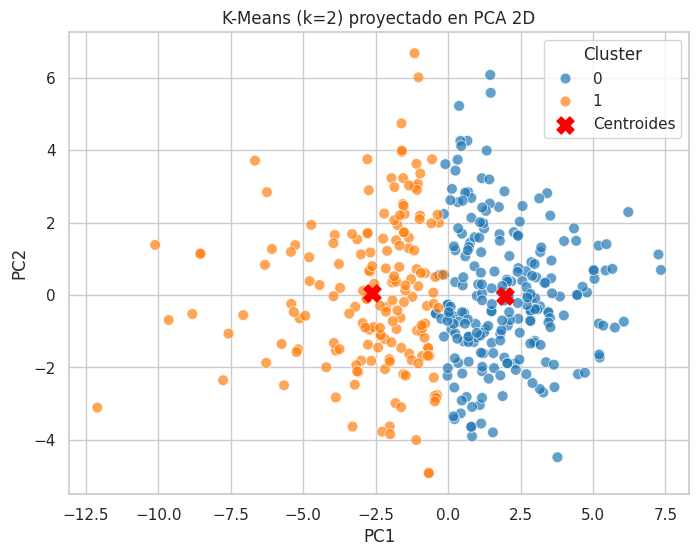

In [11]:
# VISUALIZACIÓN: PCA 2D con clusters y centroides
# Para proyectar centroides usaremos PCA ya ajustado
centroids = km_final.cluster_centers_
centroids_pca = pca.transform(centroids)  # proyectar centroides al mismo PCA

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=60, alpha=0.7)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=150, marker='X', label='Centroides')
plt.title(f"K-Means (k={k_opt}) proyectado en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

## K-MEANS (k=4)

In [12]:
# ============================================================
# APLICAR K-MEANS CON k=4
# ============================================================

km_4 = KMeans(n_clusters=4, random_state=42, n_init=50)
labels_4 = km_4.fit_predict(X_scaled)

In [13]:
# ============================================================
# VALIDACIÓN INTERNA
# ============================================================
sil = silhouette_score(X_scaled, labels_4)
db = davies_bouldin_score(X_scaled, labels_4)
ch = calinski_harabasz_score(X_scaled, labels_4)
print("Silhouette:", round(sil,3))
print("Davies-Bouldin:", round(db,3))
print("Calinski-Harabasz:", round(ch,1))

Silhouette: 0.056
Davies-Bouldin: 2.922
Calinski-Harabasz: 29.8


In [14]:
# VALIDACIÓN EXTERNA (si hay etiqueta)
if y_true is not None:
    # codificar etiquetas si son strings
    if y_true.dtype == object or y_true.dtype.name == 'category':
        y_codes = pd.Categorical(y_true).codes
    else:
        y_codes = y_true
    ari = adjusted_rand_score(y_codes, labels_4)
    print("Adjusted Rand Index (ARI):", round(ari,3))
else:
    print("Etiqueta no disponible: solo validación interna realizada.")

Adjusted Rand Index (ARI): 0.291


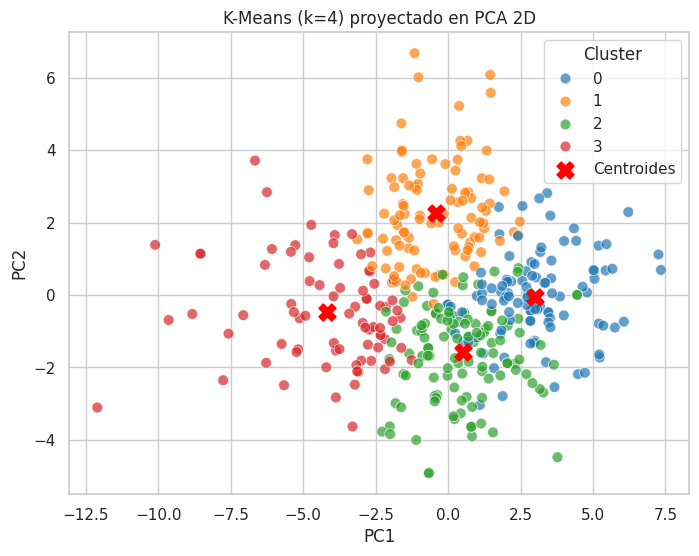

In [15]:
# VISUALIZACIÓN: PCA 2D con clusters y centroides
# Para proyectar centroides usaremos PCA ya ajustado
centroids = km_4.cluster_centers_
centroids_pca = pca.transform(centroids)  # proyectar centroides al mismo PCA

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_4, palette='tab10', s=60, alpha=0.7)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=150, marker='X', label='Centroides')
plt.title(f"K-Means (k=4) proyectado en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

## K-MEANS (k=5)

In [16]:
# ============================================================
# APLICAR K-MEANS CON k=5
# ============================================================

km_5 = KMeans(n_clusters=5, random_state=42, n_init=50)
labels_5 = km_5.fit_predict(X_scaled)

In [17]:
# ============================================================
# VALIDACIÓN INTERNA
# ============================================================
sil = silhouette_score(X_scaled, labels_5)
db = davies_bouldin_score(X_scaled, labels_5)
ch = calinski_harabasz_score(X_scaled, labels_5)
print("Silhouette:", round(sil,3))
print("Davies-Bouldin:", round(db,3))
print("Calinski-Harabasz:", round(ch,1))

Silhouette: 0.06
Davies-Bouldin: 2.771
Calinski-Harabasz: 26.4


In [18]:
# VALIDACIÓN EXTERNA (si hay etiqueta)
if y_true is not None:
    # codificar etiquetas si son strings
    if y_true.dtype == object or y_true.dtype.name == 'category':
        y_codes = pd.Categorical(y_true).codes
    else:
        y_codes = y_true
    ari = adjusted_rand_score(y_codes, labels_5)
    print("Adjusted Rand Index (ARI):", round(ari,3))
else:
    print("Etiqueta no disponible: solo validación interna realizada.")

Adjusted Rand Index (ARI): 0.232


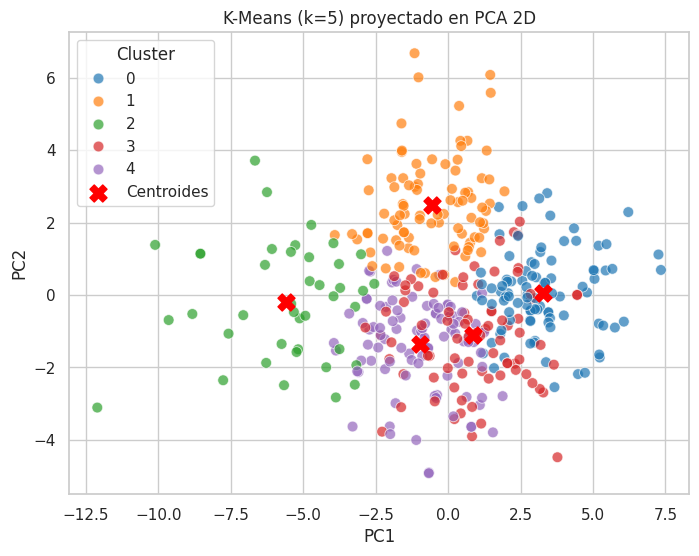

In [19]:
# VISUALIZACIÓN: PCA 2D con clusters y centroides
# Para proyectar centroides usaremos PCA ya ajustado
centroids = km_5.cluster_centers_
centroids_pca = pca.transform(centroids)  # proyectar centroides al mismo PCA

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_5, palette='tab10', s=60, alpha=0.7)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=150, marker='X', label='Centroides')
plt.title(f"K-Means (k=5) proyectado en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()